In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [3]:
df = pd.read_parquet('../data/btcusd_precrd_regression.parquet')
df.info()
df.describe()
df = df[150000:]

<class 'pandas.core.frame.DataFrame'>
Index: 442668 entries, 41 to 450017
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   open            442668 non-null  float64
 1   high            442668 non-null  float64
 2   low             442668 non-null  float64
 3   close           442668 non-null  float64
 4   BB_up_diff      442668 non-null  float64
 5   BB_down_diff    442668 non-null  float64
 6   OBV_Z           442545 non-null  float64
 7   MACD_Histogram  442668 non-null  float64
 8   RSI             442668 non-null  float64
 9   CCI             442668 non-null  float64
 10  predict_trend   442663 non-null  float64
dtypes: float64(11)
memory usage: 40.5 MB


In [4]:

# Assuming 'df' is your DataFrame with a 'price' column
df['log_return'] = np.log(df['close'] / df['close'].shift(-1))

# Create features
window = 48
df['momentum'] = df['log_return'].rolling(window).mean()
df['volatility'] = df['log_return'].rolling(window).std()

# Prepare features for clustering
features = ['momentum', 'volatility']
X = df[features].dropna()

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply K-means clustering
n_clusters = 2  # For high and low volatility regimes
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Assign regimes to the same index as X
df.loc[X.index, 'regime'] = kmeans.fit_predict(X_scaled)



# Print regime distribution
print(df['regime'].value_counts(normalize=True))

regime
1.0    0.879287
0.0    0.120713
Name: proportion, dtype: float64


In [5]:
def smooth_regimes(df, column, window_size):
    # Create a copy of the column to avoid modifying the original
    smoothed_column = df[column].copy()

    # Iterate over the DataFrame in steps of the window size
    for i in range(0, len(df), window_size):
        # Get the current window
        window = smoothed_column.iloc[i:i+window_size]
        
        # Calculate the mode of the window
        mode = window.mode()
        
        # If mode exists, fill the entire window with the mode
        if not mode.empty:
            smoothed_column.iloc[i:i+window_size] = mode[0]
    
    return smoothed_column
# Example usage
df['smoothed_regimes'] = smooth_regimes(df, 'regime', 24)
print(df['smoothed_regimes'].value_counts(normalize=True))

smoothed_regimes
1.0    0.88133
0.0    0.11867
Name: proportion, dtype: float64


In [6]:
df['regime'].describe()

count    292620.000000
mean          0.879287
std           0.325794
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: regime, dtype: float64

/var/folders/gn/mtbdxhjn1697bp_qhyd6y0cr0000gn/T/ipykernel_21902/3241924298.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['smoothed_regimes'].fillna(df['smoothed_regimes'].mode()[0], inplace=True)


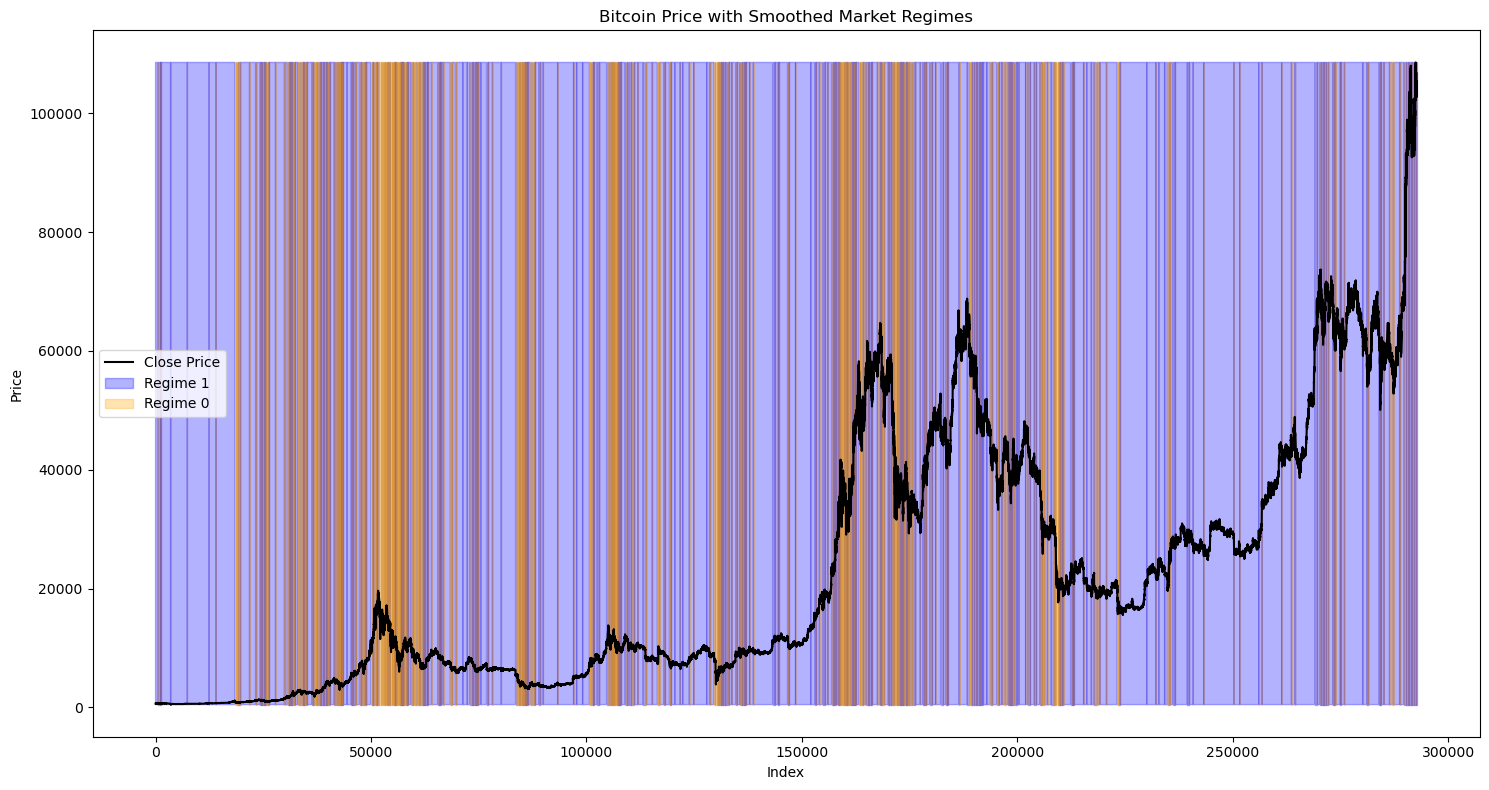

<Figure size 1500x800 with 0 Axes>

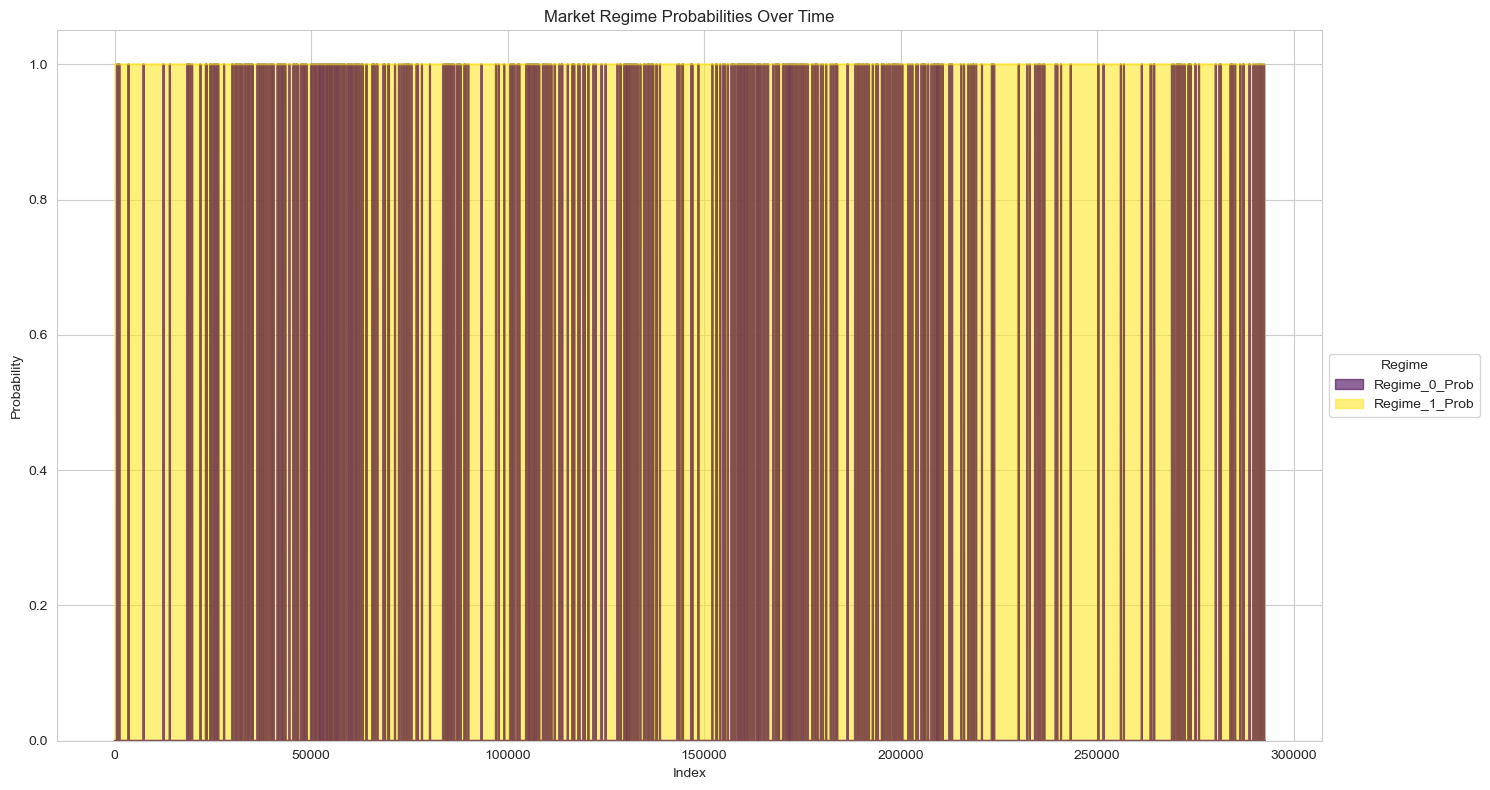

In [7]:


# Line plot with regime shading
df['smoothed_regimes'].fillna(df['smoothed_regimes'].mode()[0], inplace=True)
df.reset_index(inplace=True)

# Line plot with regime shading
plt.figure(figsize=(15, 8))
sns.lineplot(data=df, x=df.index, y='close', color='black', label='Close Price')

# Shade background by regime
for regime in df['smoothed_regimes'].unique():
    mask = df['smoothed_regimes'] == regime
    plt.fill_between(
        df.index, 
        df['close'].min(), 
        df['close'].max(), 
        where=mask, 
        alpha=0.3, 
        label=f'Regime {int(regime)}', 
        color='blue' if regime == 1 else 'orange'
    )

plt.title('Bitcoin Price with Smoothed Market Regimes')
plt.xlabel('Index')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

# Improved Stacked Area Chart of Regime Probabilities
# Create probability columns for each regime
n_regimes = df['smoothed_regimes'].nunique()
for i in range(n_regimes):
    df[f'Regime_{i}_Prob'] = (df['smoothed_regimes'] == i).astype(int)

# Create the stacked area plot
plt.figure(figsize=(15, 8))
sns.set_style("whitegrid")
sns.set_palette("husl", n_colors=n_regimes)

df[[f'Regime_{i}_Prob' for i in range(n_regimes)]].plot.area(stacked=True, alpha=0.6, figsize=(15, 8), cmap='viridis')

plt.title('Market Regime Probabilities Over Time')
plt.xlabel('Index')
plt.ylabel('Probability')
plt.legend(title='Regime', loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [8]:
df.drop(columns=['index', 'log_return',	'momentum',	'volatility', 'Regime_0_Prob',	'Regime_1_Prob'], inplace=True)
df.to_parquet('../data/btcusd_preprcd_with_regimes.parquet')

In [9]:
df['smoothed_regimes'].value_counts()

smoothed_regimes
1.0    257940
0.0     34728
Name: count, dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292668 entries, 0 to 292667
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   open              292668 non-null  float64
 1   high              292668 non-null  float64
 2   low               292668 non-null  float64
 3   close             292668 non-null  float64
 4   BB_up_diff        292668 non-null  float64
 5   BB_down_diff      292668 non-null  float64
 6   OBV_Z             292668 non-null  float64
 7   MACD_Histogram    292668 non-null  float64
 8   RSI               292668 non-null  float64
 9   CCI               292668 non-null  float64
 10  predict_trend     292663 non-null  float64
 11  regime            292620 non-null  float64
 12  smoothed_regimes  292668 non-null  float64
dtypes: float64(13)
memory usage: 29.0 MB


In [11]:
df['predict_trend'].describe()

count    292663.000000
mean          0.823045
std         143.941663
min       -6669.066665
25%         -21.666667
50%           0.186000
75%          23.266667
max        6293.066669
Name: predict_trend, dtype: float64

In [12]:
df['classy'] = np.where(df['predict_trend'] > 20, 1, np.where(df['predict_trend'] < -20, -1, 0))

In [13]:
df.to_parquet('../data/btcusd_preprcd_with_regimes_and_classy.parquet')